# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import albumentations
import albumentations.pytorch

In [2]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


# Dataset and Creating Train/Test Split

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import CIFAR10
import cv2

class AlbumentationsTransform:
    def __init__(self, augmentations):
        self.augmentations = A.Compose(augmentations)

    def __call__(self, image):
        augmented = self.augmentations(image=np.array(image))
        return augmented['image']

# Calculate mean of CIFAR-10 dataset
cifar10_mean = (0.5, 0.5, 0.5)  # Replace with actual mean if available

# Define Albumentations augmentations
augmentations = [
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=(0.9, 1.1), rotate_limit=(-7, 7), border_mode=cv2.BORDER_CONSTANT, value=1),
    A.CoarseDropout(max_holes=1, max_height=5, max_width=5, min_holes=1, min_height=2, min_width=2, fill_value=cifar10_mean, mask_fill_value=None),
    A.Normalize(mean=cifar10_mean, std=(0.5, 0.5, 0.5)),
    ToTensorV2()
]

# Define Albumentations transform
albumentations_transform = AlbumentationsTransform(augmentations)

# CIFAR-10 dataset and dataloader
train = datasets.CIFAR10(root='./data', train=True, transform=None, download=True)
test = datasets.CIFAR10(root='./data', train=False, transform=None, download=True)

# Apply Albumentations transform to dataset
train.transform = albumentations_transform
test.transform = albumentations_transform


100%|██████████| 170498071/170498071 [00:03<00:00, 48989066.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1
BATCH_SIZE = 32
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

CUDA Available? True


In [5]:
print(len(train_loader))
print(len(test_loader))

1563
313


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

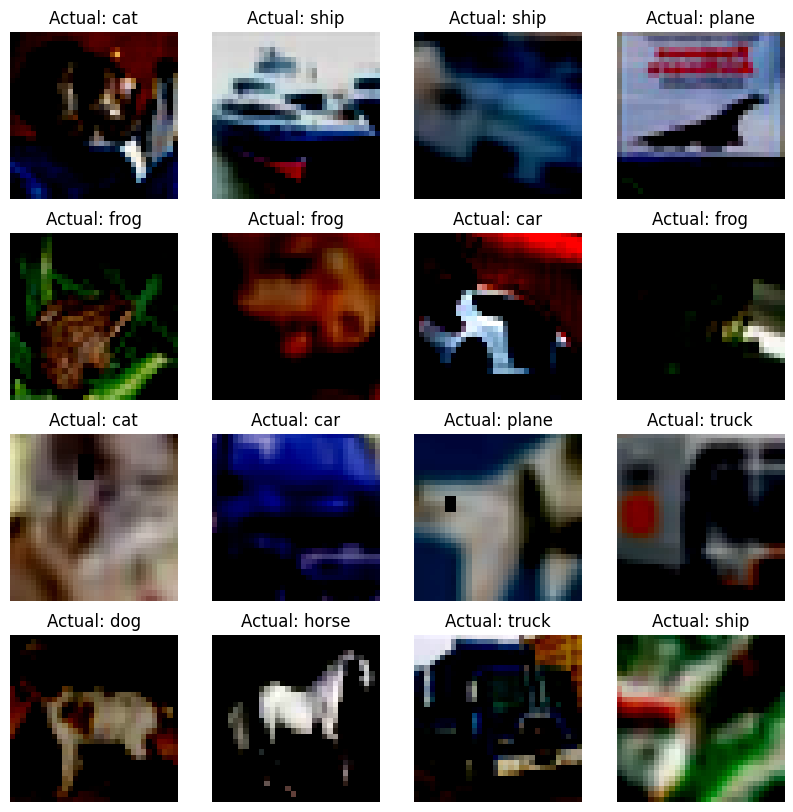

In [8]:
import numpy as np
dataiter = iter(test_loader)
#print(next(dataiter))
images, labels = next(iter(test_loader))

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(f'Actual: {classes[labels[i]]}')
    ax.axis('off')

plt.show()

# The model
Let's start with the model we first saw

In [ ]:
'''class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.input = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # CONVOLUTION BLOCK 1
        # Depthwise sperable layer
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(in_channels=30, out_channels=30, kernel_size=3, padding=1, groups=3), #### Depthwise convolution
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(in_channels=30, out_channels=32, kernel_size=1), ### Pointwise Convolution (using depthwise output) <-- This is called DEPTHWISE-SEPARABLE CONVOLUTION
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # CONVOLUTION BLOCK 2 - Dialated Convolution
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False,dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )

        self.dropout = nn.Dropout(0.01)

        # First fully connected layer
        self.fc1 = nn.Linear(128*8*8, 100) # [ [BATCH_SIZE] * [CHANNEL_NUMBER] * [HEIGHT] * [WIDTH].]
        self.fc2 = nn.Linear(100, 10) # [ [BATCH_SIZE] * [CHANNEL_NUMBER] * [HEIGHT] * [WIDTH].]

    def forward(self, x):
        x = self.input(x)
        #print('input layer - ',x.shape)
        x = self.convblock1(x)
        #print('conv1 - ',x.shape)
        x = self.convblock2(x)
        #print('conv2 - ',x.shape)
        x = self.convblock3(x)
        #print('conv3 - ',x.shape)
        x = self.convblock4(x)
        #print('conv4 - ',x.shape)
        x = self.gap(x)
        #print('Gap - ',x.shape)
        #print(x.view(-1, x.shape[-1]))
        x = x.view(-1, 128*8*8) #[CHANNEL_NUMBER] * [HEIGHT] * [WIDTH]
        #print('Flatten - ', x.view(-1, x.shape[-1]).shape[0])
        x = self.fc1(x)
        x = self.fc2(x)
        #print('Linear - ',x.shape)
        return F.log_softmax(x, dim=-1)'''


In [9]:
# importing the model from the model.py

#import model
from model import Net

model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 30, 30, 30]           8,640
       BatchNorm2d-5           [-1, 30, 30, 30]              60
              ReLU-6           [-1, 30, 30, 30]               0
            Conv2d-7           [-1, 30, 30, 30]           2,730
       BatchNorm2d-8           [-1, 30, 30, 30]              60
              ReLU-9           [-1, 30, 30, 30]               0
           Conv2d-10           [-1, 32, 30, 30]             992
      BatchNorm2d-11           [-1, 32, 30, 30]              64
             ReLU-12           [-1, 32, 30, 30]               0
           Conv2d-13           [-1, 64, 28, 28]          18,432
      BatchNorm2d-14           [-1, 64,

# Training and Testing

In [10]:
# Function fopr Training the model of the train dataset.
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Calculate loss
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        #pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

# Testing the trained model on test dataset to the check loss and model accuracy
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




# Let's Train and test our model

In [12]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 150
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)

    test(model, device, test_loader)



EPOCH: 1


Train: Loss=2.0758 Batch_id=1562 Accuracy=31.96: 100%|██████████| 1563/1563 [00:52<00:00, 29.57it/s]



Test set: Average loss: 1.6554, Accuracy: 3902/10000 (39.02%)

EPOCH: 2


Train: Loss=1.7510 Batch_id=1562 Accuracy=42.54: 100%|██████████| 1563/1563 [00:51<00:00, 30.55it/s]



Test set: Average loss: 1.4819, Accuracy: 4653/10000 (46.53%)

EPOCH: 3


Train: Loss=1.4436 Batch_id=1562 Accuracy=49.41: 100%|██████████| 1563/1563 [00:50<00:00, 30.73it/s]



Test set: Average loss: 1.3168, Accuracy: 5251/10000 (52.51%)

EPOCH: 4


Train: Loss=1.4009 Batch_id=1562 Accuracy=54.17: 100%|██████████| 1563/1563 [00:50<00:00, 30.99it/s]



Test set: Average loss: 1.2677, Accuracy: 5437/10000 (54.37%)

EPOCH: 5


Train: Loss=1.3010 Batch_id=1562 Accuracy=57.35: 100%|██████████| 1563/1563 [00:50<00:00, 30.88it/s]



Test set: Average loss: 1.1367, Accuracy: 5938/10000 (59.38%)

EPOCH: 6


Train: Loss=1.5121 Batch_id=1562 Accuracy=60.03: 100%|██████████| 1563/1563 [00:50<00:00, 30.93it/s]



Test set: Average loss: 1.1078, Accuracy: 6098/10000 (60.98%)

EPOCH: 7


Train: Loss=0.6776 Batch_id=1562 Accuracy=62.16: 100%|██████████| 1563/1563 [00:50<00:00, 31.02it/s]



Test set: Average loss: 1.0786, Accuracy: 6152/10000 (61.52%)

EPOCH: 8


Train: Loss=0.7770 Batch_id=1562 Accuracy=63.49: 100%|██████████| 1563/1563 [00:50<00:00, 30.76it/s]



Test set: Average loss: 0.9996, Accuracy: 6439/10000 (64.39%)

EPOCH: 9


Train: Loss=0.9788 Batch_id=1562 Accuracy=65.04: 100%|██████████| 1563/1563 [00:50<00:00, 30.66it/s]



Test set: Average loss: 0.9793, Accuracy: 6550/10000 (65.50%)

EPOCH: 10


Train: Loss=0.6703 Batch_id=1562 Accuracy=66.25: 100%|██████████| 1563/1563 [00:50<00:00, 30.83it/s]



Test set: Average loss: 0.9485, Accuracy: 6651/10000 (66.51%)

EPOCH: 11


Train: Loss=0.9950 Batch_id=1562 Accuracy=66.98: 100%|██████████| 1563/1563 [00:50<00:00, 30.94it/s]



Test set: Average loss: 0.9471, Accuracy: 6623/10000 (66.23%)

EPOCH: 12


Train: Loss=0.7106 Batch_id=1562 Accuracy=68.21: 100%|██████████| 1563/1563 [00:50<00:00, 30.68it/s]



Test set: Average loss: 0.9392, Accuracy: 6722/10000 (67.22%)

EPOCH: 13


Train: Loss=1.3368 Batch_id=1562 Accuracy=68.50: 100%|██████████| 1563/1563 [00:50<00:00, 30.94it/s]



Test set: Average loss: 0.8851, Accuracy: 6906/10000 (69.06%)

EPOCH: 14


Train: Loss=1.2800 Batch_id=1562 Accuracy=69.45: 100%|██████████| 1563/1563 [00:50<00:00, 30.87it/s]



Test set: Average loss: 0.8900, Accuracy: 6870/10000 (68.70%)

EPOCH: 15


Train: Loss=0.4044 Batch_id=1562 Accuracy=70.23: 100%|██████████| 1563/1563 [00:50<00:00, 31.01it/s]



Test set: Average loss: 0.8916, Accuracy: 6897/10000 (68.97%)

EPOCH: 16


Train: Loss=0.8911 Batch_id=1562 Accuracy=70.86: 100%|██████████| 1563/1563 [00:50<00:00, 30.76it/s]



Test set: Average loss: 0.8396, Accuracy: 7063/10000 (70.63%)

EPOCH: 17


Train: Loss=0.4968 Batch_id=1562 Accuracy=71.22: 100%|██████████| 1563/1563 [00:50<00:00, 30.80it/s]



Test set: Average loss: 0.8405, Accuracy: 7119/10000 (71.19%)

EPOCH: 18


Train: Loss=0.7160 Batch_id=1562 Accuracy=71.96: 100%|██████████| 1563/1563 [00:50<00:00, 30.91it/s]



Test set: Average loss: 0.8296, Accuracy: 7121/10000 (71.21%)

EPOCH: 19


Train: Loss=0.8535 Batch_id=1562 Accuracy=72.40: 100%|██████████| 1563/1563 [00:51<00:00, 30.42it/s]



Test set: Average loss: 0.8157, Accuracy: 7148/10000 (71.48%)

EPOCH: 20


Train: Loss=1.0809 Batch_id=1562 Accuracy=73.00: 100%|██████████| 1563/1563 [00:50<00:00, 30.82it/s]



Test set: Average loss: 0.8441, Accuracy: 7070/10000 (70.70%)

EPOCH: 21


Train: Loss=0.8519 Batch_id=1562 Accuracy=73.26: 100%|██████████| 1563/1563 [00:50<00:00, 30.82it/s]



Test set: Average loss: 0.8345, Accuracy: 7075/10000 (70.75%)

EPOCH: 22


Train: Loss=0.6721 Batch_id=1562 Accuracy=73.68: 100%|██████████| 1563/1563 [00:51<00:00, 30.52it/s]



Test set: Average loss: 0.7808, Accuracy: 7315/10000 (73.15%)

EPOCH: 23


Train: Loss=0.9018 Batch_id=1562 Accuracy=74.10: 100%|██████████| 1563/1563 [00:50<00:00, 30.91it/s]



Test set: Average loss: 0.8315, Accuracy: 7161/10000 (71.61%)

EPOCH: 24


Train: Loss=1.0453 Batch_id=1562 Accuracy=74.45: 100%|██████████| 1563/1563 [00:50<00:00, 30.93it/s]



Test set: Average loss: 0.8091, Accuracy: 7250/10000 (72.50%)

EPOCH: 25


Train: Loss=0.6827 Batch_id=1562 Accuracy=74.91: 100%|██████████| 1563/1563 [00:50<00:00, 30.92it/s]



Test set: Average loss: 0.7813, Accuracy: 7310/10000 (73.10%)

EPOCH: 26


Train: Loss=0.5722 Batch_id=1562 Accuracy=75.21: 100%|██████████| 1563/1563 [00:51<00:00, 30.37it/s]



Test set: Average loss: 0.7890, Accuracy: 7289/10000 (72.89%)

EPOCH: 27


Train: Loss=0.3595 Batch_id=1562 Accuracy=75.63: 100%|██████████| 1563/1563 [00:50<00:00, 30.83it/s]



Test set: Average loss: 0.7696, Accuracy: 7346/10000 (73.46%)

EPOCH: 28


Train: Loss=0.9843 Batch_id=1562 Accuracy=76.02: 100%|██████████| 1563/1563 [00:50<00:00, 30.79it/s]



Test set: Average loss: 0.7356, Accuracy: 7485/10000 (74.85%)

EPOCH: 29


Train: Loss=0.1499 Batch_id=1562 Accuracy=76.20: 100%|██████████| 1563/1563 [00:51<00:00, 30.56it/s]



Test set: Average loss: 0.7461, Accuracy: 7435/10000 (74.35%)

EPOCH: 30


Train: Loss=0.7687 Batch_id=1562 Accuracy=76.25: 100%|██████████| 1563/1563 [00:50<00:00, 30.74it/s]



Test set: Average loss: 0.7300, Accuracy: 7503/10000 (75.03%)

EPOCH: 31


Train: Loss=0.9142 Batch_id=1562 Accuracy=77.00: 100%|██████████| 1563/1563 [00:50<00:00, 30.80it/s]



Test set: Average loss: 0.7796, Accuracy: 7355/10000 (73.55%)

EPOCH: 32


Train: Loss=0.6373 Batch_id=1562 Accuracy=77.08: 100%|██████████| 1563/1563 [00:50<00:00, 30.83it/s]



Test set: Average loss: 0.7418, Accuracy: 7449/10000 (74.49%)

EPOCH: 33


Train: Loss=0.9354 Batch_id=1562 Accuracy=77.23: 100%|██████████| 1563/1563 [00:51<00:00, 30.63it/s]



Test set: Average loss: 0.7481, Accuracy: 7521/10000 (75.21%)

EPOCH: 34


Train: Loss=0.4572 Batch_id=1562 Accuracy=77.58: 100%|██████████| 1563/1563 [00:50<00:00, 30.93it/s]



Test set: Average loss: 0.7264, Accuracy: 7510/10000 (75.10%)

EPOCH: 35


Train: Loss=0.5427 Batch_id=1562 Accuracy=77.63: 100%|██████████| 1563/1563 [00:50<00:00, 30.82it/s]



Test set: Average loss: 0.7388, Accuracy: 7497/10000 (74.97%)

EPOCH: 36


Train: Loss=0.8777 Batch_id=1562 Accuracy=78.07: 100%|██████████| 1563/1563 [00:51<00:00, 30.47it/s]



Test set: Average loss: 0.7384, Accuracy: 7438/10000 (74.38%)

EPOCH: 37


Train: Loss=0.4154 Batch_id=1562 Accuracy=78.36: 100%|██████████| 1563/1563 [00:50<00:00, 30.79it/s]



Test set: Average loss: 0.6916, Accuracy: 7571/10000 (75.71%)

EPOCH: 38


Train: Loss=0.5725 Batch_id=1562 Accuracy=78.65: 100%|██████████| 1563/1563 [00:51<00:00, 30.52it/s]



Test set: Average loss: 0.6967, Accuracy: 7603/10000 (76.03%)

EPOCH: 39


Train: Loss=0.6216 Batch_id=1562 Accuracy=78.75: 100%|██████████| 1563/1563 [00:51<00:00, 30.51it/s]



Test set: Average loss: 0.7120, Accuracy: 7539/10000 (75.39%)

EPOCH: 40


Train: Loss=0.6145 Batch_id=1562 Accuracy=79.01: 100%|██████████| 1563/1563 [00:51<00:00, 30.50it/s]



Test set: Average loss: 0.6910, Accuracy: 7611/10000 (76.11%)

EPOCH: 41


Train: Loss=0.6017 Batch_id=1562 Accuracy=78.96: 100%|██████████| 1563/1563 [00:51<00:00, 30.48it/s]



Test set: Average loss: 0.7104, Accuracy: 7635/10000 (76.35%)

EPOCH: 42


Train: Loss=0.9989 Batch_id=1562 Accuracy=79.40: 100%|██████████| 1563/1563 [00:51<00:00, 30.49it/s]



Test set: Average loss: 0.7000, Accuracy: 7619/10000 (76.19%)

EPOCH: 43


Train: Loss=0.9050 Batch_id=1562 Accuracy=79.45: 100%|██████████| 1563/1563 [00:52<00:00, 30.04it/s]



Test set: Average loss: 0.7119, Accuracy: 7591/10000 (75.91%)

EPOCH: 44


Train: Loss=0.9291 Batch_id=1562 Accuracy=79.59: 100%|██████████| 1563/1563 [00:51<00:00, 30.29it/s]



Test set: Average loss: 0.6800, Accuracy: 7693/10000 (76.93%)

EPOCH: 45


Train: Loss=0.5328 Batch_id=1562 Accuracy=79.84: 100%|██████████| 1563/1563 [00:51<00:00, 30.41it/s]



Test set: Average loss: 0.7093, Accuracy: 7580/10000 (75.80%)

EPOCH: 46


Train: Loss=0.2232 Batch_id=1562 Accuracy=80.00: 100%|██████████| 1563/1563 [00:52<00:00, 29.93it/s]



Test set: Average loss: 0.6668, Accuracy: 7711/10000 (77.11%)

EPOCH: 47


Train: Loss=0.9713 Batch_id=1562 Accuracy=80.28: 100%|██████████| 1563/1563 [00:51<00:00, 30.36it/s]



Test set: Average loss: 0.6857, Accuracy: 7679/10000 (76.79%)

EPOCH: 48


Train: Loss=0.6617 Batch_id=1562 Accuracy=80.48: 100%|██████████| 1563/1563 [00:51<00:00, 30.07it/s]



Test set: Average loss: 0.6741, Accuracy: 7680/10000 (76.80%)

EPOCH: 49


Train: Loss=0.4385 Batch_id=1562 Accuracy=80.51: 100%|██████████| 1563/1563 [00:51<00:00, 30.35it/s]



Test set: Average loss: 0.6887, Accuracy: 7688/10000 (76.88%)

EPOCH: 50


Train: Loss=0.4836 Batch_id=1562 Accuracy=80.72: 100%|██████████| 1563/1563 [00:52<00:00, 30.02it/s]



Test set: Average loss: 0.6905, Accuracy: 7723/10000 (77.23%)

EPOCH: 51


Train: Loss=0.5671 Batch_id=1562 Accuracy=80.87: 100%|██████████| 1563/1563 [00:51<00:00, 30.34it/s]



Test set: Average loss: 0.6729, Accuracy: 7718/10000 (77.18%)

EPOCH: 52


Train: Loss=0.4350 Batch_id=1562 Accuracy=81.16: 100%|██████████| 1563/1563 [00:51<00:00, 30.40it/s]



Test set: Average loss: 0.6744, Accuracy: 7739/10000 (77.39%)

EPOCH: 53


Train: Loss=0.5844 Batch_id=1562 Accuracy=81.34: 100%|██████████| 1563/1563 [00:52<00:00, 29.94it/s]



Test set: Average loss: 0.6598, Accuracy: 7760/10000 (77.60%)

EPOCH: 54


Train: Loss=1.1930 Batch_id=1562 Accuracy=81.43: 100%|██████████| 1563/1563 [00:51<00:00, 30.42it/s]



Test set: Average loss: 0.6731, Accuracy: 7676/10000 (76.76%)

EPOCH: 55


Train: Loss=0.5412 Batch_id=1562 Accuracy=81.57: 100%|██████████| 1563/1563 [00:51<00:00, 30.43it/s]



Test set: Average loss: 0.6872, Accuracy: 7728/10000 (77.28%)

EPOCH: 56


Train: Loss=0.4734 Batch_id=1562 Accuracy=81.53: 100%|██████████| 1563/1563 [00:51<00:00, 30.09it/s]



Test set: Average loss: 0.6886, Accuracy: 7716/10000 (77.16%)

EPOCH: 57


Train: Loss=0.5698 Batch_id=1562 Accuracy=82.06: 100%|██████████| 1563/1563 [00:51<00:00, 30.28it/s]



Test set: Average loss: 0.6589, Accuracy: 7825/10000 (78.25%)

EPOCH: 58


Train: Loss=0.5288 Batch_id=1562 Accuracy=81.84: 100%|██████████| 1563/1563 [00:51<00:00, 30.31it/s]



Test set: Average loss: 0.6711, Accuracy: 7764/10000 (77.64%)

EPOCH: 59


Train: Loss=0.2637 Batch_id=1562 Accuracy=82.05: 100%|██████████| 1563/1563 [00:51<00:00, 30.31it/s]



Test set: Average loss: 0.6683, Accuracy: 7716/10000 (77.16%)

EPOCH: 60


Train: Loss=0.7980 Batch_id=1562 Accuracy=82.02: 100%|██████████| 1563/1563 [00:52<00:00, 29.95it/s]



Test set: Average loss: 0.6857, Accuracy: 7752/10000 (77.52%)

EPOCH: 61


Train: Loss=0.3412 Batch_id=1562 Accuracy=82.14: 100%|██████████| 1563/1563 [00:51<00:00, 30.41it/s]



Test set: Average loss: 0.6905, Accuracy: 7731/10000 (77.31%)

EPOCH: 62


Train: Loss=0.5864 Batch_id=1562 Accuracy=82.23: 100%|██████████| 1563/1563 [00:51<00:00, 30.30it/s]



Test set: Average loss: 0.6708, Accuracy: 7807/10000 (78.07%)

EPOCH: 63


Train: Loss=0.4054 Batch_id=1562 Accuracy=82.55: 100%|██████████| 1563/1563 [00:51<00:00, 30.09it/s]



Test set: Average loss: 0.6501, Accuracy: 7845/10000 (78.45%)

EPOCH: 64


Train: Loss=0.4098 Batch_id=1562 Accuracy=82.50: 100%|██████████| 1563/1563 [00:51<00:00, 30.26it/s]



Test set: Average loss: 0.6576, Accuracy: 7796/10000 (77.96%)

EPOCH: 65


Train: Loss=0.7003 Batch_id=1562 Accuracy=82.76: 100%|██████████| 1563/1563 [00:51<00:00, 30.44it/s]



Test set: Average loss: 0.6573, Accuracy: 7857/10000 (78.57%)

EPOCH: 66


Train: Loss=0.6895 Batch_id=1562 Accuracy=82.86: 100%|██████████| 1563/1563 [00:51<00:00, 30.35it/s]



Test set: Average loss: 0.6655, Accuracy: 7772/10000 (77.72%)

EPOCH: 67


Train: Loss=0.5488 Batch_id=1562 Accuracy=82.98: 100%|██████████| 1563/1563 [00:51<00:00, 30.16it/s]



Test set: Average loss: 0.6599, Accuracy: 7771/10000 (77.71%)

EPOCH: 68


Train: Loss=0.2543 Batch_id=1562 Accuracy=83.18: 100%|██████████| 1563/1563 [00:51<00:00, 30.38it/s]



Test set: Average loss: 0.6356, Accuracy: 7861/10000 (78.61%)

EPOCH: 69


Train: Loss=0.6855 Batch_id=1562 Accuracy=83.28: 100%|██████████| 1563/1563 [00:51<00:00, 30.43it/s]



Test set: Average loss: 0.6853, Accuracy: 7746/10000 (77.46%)

EPOCH: 70


Train: Loss=0.9615 Batch_id=1562 Accuracy=83.36: 100%|██████████| 1563/1563 [00:52<00:00, 30.01it/s]



Test set: Average loss: 0.6360, Accuracy: 7853/10000 (78.53%)

EPOCH: 71


Train: Loss=0.9298 Batch_id=1562 Accuracy=83.27: 100%|██████████| 1563/1563 [00:51<00:00, 30.43it/s]



Test set: Average loss: 0.6605, Accuracy: 7835/10000 (78.35%)

EPOCH: 72


Train: Loss=0.4211 Batch_id=1562 Accuracy=83.48: 100%|██████████| 1563/1563 [00:51<00:00, 30.29it/s]



Test set: Average loss: 0.6587, Accuracy: 7851/10000 (78.51%)

EPOCH: 73


Train: Loss=0.6000 Batch_id=1562 Accuracy=83.60: 100%|██████████| 1563/1563 [00:51<00:00, 30.06it/s]



Test set: Average loss: 0.6444, Accuracy: 7850/10000 (78.50%)

EPOCH: 74


Train: Loss=0.2891 Batch_id=1562 Accuracy=83.70: 100%|██████████| 1563/1563 [00:51<00:00, 30.36it/s]



Test set: Average loss: 0.6507, Accuracy: 7858/10000 (78.58%)

EPOCH: 75


Train: Loss=0.8111 Batch_id=1562 Accuracy=83.82: 100%|██████████| 1563/1563 [00:51<00:00, 30.48it/s]



Test set: Average loss: 0.6564, Accuracy: 7897/10000 (78.97%)

EPOCH: 76


Train: Loss=0.7266 Batch_id=1562 Accuracy=83.93: 100%|██████████| 1563/1563 [00:51<00:00, 30.44it/s]



Test set: Average loss: 0.6487, Accuracy: 7911/10000 (79.11%)

EPOCH: 77


Train: Loss=0.3895 Batch_id=1562 Accuracy=83.91: 100%|██████████| 1563/1563 [00:52<00:00, 29.94it/s]



Test set: Average loss: 0.6188, Accuracy: 7922/10000 (79.22%)

EPOCH: 78


Train: Loss=0.5095 Batch_id=1562 Accuracy=84.05: 100%|██████████| 1563/1563 [00:51<00:00, 30.42it/s]



Test set: Average loss: 0.6737, Accuracy: 7794/10000 (77.94%)

EPOCH: 79


Train: Loss=0.1503 Batch_id=1562 Accuracy=84.41: 100%|██████████| 1563/1563 [00:51<00:00, 30.13it/s]



Test set: Average loss: 0.6523, Accuracy: 7923/10000 (79.23%)

EPOCH: 80


Train: Loss=0.4198 Batch_id=1562 Accuracy=84.21: 100%|██████████| 1563/1563 [00:52<00:00, 30.03it/s]



Test set: Average loss: 0.6546, Accuracy: 7837/10000 (78.37%)

EPOCH: 81


Train: Loss=0.7122 Batch_id=1562 Accuracy=84.41: 100%|██████████| 1563/1563 [00:51<00:00, 30.16it/s]



Test set: Average loss: 0.6560, Accuracy: 7830/10000 (78.30%)

EPOCH: 82


Train: Loss=0.0964 Batch_id=1562 Accuracy=84.58: 100%|██████████| 1563/1563 [00:51<00:00, 30.35it/s]



Test set: Average loss: 0.6237, Accuracy: 7907/10000 (79.07%)

EPOCH: 83


Train: Loss=0.2211 Batch_id=1562 Accuracy=84.61: 100%|██████████| 1563/1563 [00:51<00:00, 30.17it/s]



Test set: Average loss: 0.6358, Accuracy: 7928/10000 (79.28%)

EPOCH: 84


Train: Loss=0.9754 Batch_id=1562 Accuracy=84.79: 100%|██████████| 1563/1563 [00:51<00:00, 30.10it/s]



Test set: Average loss: 0.6244, Accuracy: 7932/10000 (79.32%)

EPOCH: 85


Train: Loss=0.1843 Batch_id=1562 Accuracy=84.67: 100%|██████████| 1563/1563 [00:51<00:00, 30.14it/s]



Test set: Average loss: 0.6593, Accuracy: 7892/10000 (78.92%)

EPOCH: 86


Train: Loss=0.6740 Batch_id=1562 Accuracy=85.31: 100%|██████████| 1563/1563 [00:51<00:00, 30.33it/s]



Test set: Average loss: 0.6343, Accuracy: 7949/10000 (79.49%)

EPOCH: 87


Train: Loss=0.7475 Batch_id=1562 Accuracy=85.10: 100%|██████████| 1563/1563 [00:54<00:00, 28.87it/s]



Test set: Average loss: 0.6468, Accuracy: 7923/10000 (79.23%)

EPOCH: 88


Train: Loss=0.1888 Batch_id=1562 Accuracy=84.98: 100%|██████████| 1563/1563 [00:52<00:00, 29.80it/s]



Test set: Average loss: 0.6437, Accuracy: 7921/10000 (79.21%)

EPOCH: 89


Train: Loss=0.4373 Batch_id=1562 Accuracy=85.03: 100%|██████████| 1563/1563 [00:53<00:00, 29.38it/s]



Test set: Average loss: 0.6334, Accuracy: 7958/10000 (79.58%)

EPOCH: 90


Train: Loss=0.2692 Batch_id=1562 Accuracy=85.02: 100%|██████████| 1563/1563 [00:52<00:00, 29.96it/s]



Test set: Average loss: 0.6753, Accuracy: 7903/10000 (79.03%)

EPOCH: 91


Train: Loss=0.3568 Batch_id=1562 Accuracy=85.33: 100%|██████████| 1563/1563 [00:52<00:00, 29.88it/s]



Test set: Average loss: 0.6377, Accuracy: 7923/10000 (79.23%)

EPOCH: 92


Train: Loss=0.6111 Batch_id=1562 Accuracy=85.22: 100%|██████████| 1563/1563 [00:52<00:00, 29.61it/s]



Test set: Average loss: 0.6480, Accuracy: 7888/10000 (78.88%)

EPOCH: 93


Train: Loss=0.6366 Batch_id=1562 Accuracy=85.19: 100%|██████████| 1563/1563 [00:52<00:00, 29.85it/s]



Test set: Average loss: 0.6429, Accuracy: 7946/10000 (79.46%)

EPOCH: 94


Train: Loss=0.4361 Batch_id=1562 Accuracy=85.35: 100%|██████████| 1563/1563 [00:52<00:00, 29.57it/s]



Test set: Average loss: 0.6265, Accuracy: 7934/10000 (79.34%)

EPOCH: 95


Train: Loss=0.5713 Batch_id=1562 Accuracy=85.60: 100%|██████████| 1563/1563 [00:52<00:00, 29.67it/s]



Test set: Average loss: 0.6712, Accuracy: 7866/10000 (78.66%)

EPOCH: 96


Train: Loss=0.1320 Batch_id=1562 Accuracy=85.63: 100%|██████████| 1563/1563 [00:52<00:00, 29.74it/s]



Test set: Average loss: 0.6342, Accuracy: 7974/10000 (79.74%)

EPOCH: 97


Train: Loss=0.1581 Batch_id=1562 Accuracy=85.65: 100%|██████████| 1563/1563 [00:52<00:00, 29.84it/s]



Test set: Average loss: 0.6532, Accuracy: 7929/10000 (79.29%)

EPOCH: 98


Train: Loss=0.4615 Batch_id=1562 Accuracy=85.85: 100%|██████████| 1563/1563 [00:53<00:00, 29.20it/s]



Test set: Average loss: 0.6848, Accuracy: 7837/10000 (78.37%)

EPOCH: 99


Train: Loss=0.1116 Batch_id=1562 Accuracy=85.82: 100%|██████████| 1563/1563 [00:51<00:00, 30.15it/s]



Test set: Average loss: 0.6082, Accuracy: 8022/10000 (80.22%)

EPOCH: 100


Train: Loss=0.8380 Batch_id=1562 Accuracy=85.90: 100%|██████████| 1563/1563 [00:51<00:00, 30.39it/s]



Test set: Average loss: 0.6270, Accuracy: 8025/10000 (80.25%)

EPOCH: 101


Train: Loss=1.0993 Batch_id=1562 Accuracy=86.38: 100%|██████████| 1563/1563 [00:51<00:00, 30.14it/s]



Test set: Average loss: 0.6571, Accuracy: 7888/10000 (78.88%)

EPOCH: 102


Train: Loss=0.6629 Batch_id=1562 Accuracy=86.23: 100%|██████████| 1563/1563 [00:51<00:00, 30.31it/s]



Test set: Average loss: 0.6415, Accuracy: 7896/10000 (78.96%)

EPOCH: 103


Train: Loss=0.1416 Batch_id=1562 Accuracy=86.19: 100%|██████████| 1563/1563 [00:51<00:00, 30.27it/s]



Test set: Average loss: 0.6503, Accuracy: 7934/10000 (79.34%)

EPOCH: 104


Train: Loss=0.0960 Batch_id=1562 Accuracy=86.06: 100%|██████████| 1563/1563 [00:51<00:00, 30.36it/s]



Test set: Average loss: 0.6168, Accuracy: 7977/10000 (79.77%)

EPOCH: 105


Train: Loss=0.5045 Batch_id=1562 Accuracy=86.33: 100%|██████████| 1563/1563 [00:52<00:00, 29.77it/s]



Test set: Average loss: 0.6487, Accuracy: 7898/10000 (78.98%)

EPOCH: 106


Train: Loss=0.3470 Batch_id=1562 Accuracy=86.26: 100%|██████████| 1563/1563 [00:51<00:00, 30.13it/s]



Test set: Average loss: 0.6689, Accuracy: 7949/10000 (79.49%)

EPOCH: 107


Train: Loss=0.4670 Batch_id=1562 Accuracy=86.40: 100%|██████████| 1563/1563 [00:51<00:00, 30.37it/s]



Test set: Average loss: 0.6510, Accuracy: 7967/10000 (79.67%)

EPOCH: 108


Train: Loss=0.4871 Batch_id=1562 Accuracy=86.55: 100%|██████████| 1563/1563 [00:51<00:00, 30.13it/s]



Test set: Average loss: 0.6616, Accuracy: 7903/10000 (79.03%)

EPOCH: 109


Train: Loss=0.4258 Batch_id=1562 Accuracy=86.53: 100%|██████████| 1563/1563 [00:52<00:00, 29.89it/s]



Test set: Average loss: 0.6718, Accuracy: 7872/10000 (78.72%)

EPOCH: 110


Train: Loss=0.2383 Batch_id=1562 Accuracy=86.65: 100%|██████████| 1563/1563 [00:51<00:00, 30.29it/s]



Test set: Average loss: 0.6393, Accuracy: 7937/10000 (79.37%)

EPOCH: 111


Train: Loss=0.2728 Batch_id=1562 Accuracy=86.59: 100%|██████████| 1563/1563 [00:51<00:00, 30.31it/s]



Test set: Average loss: 0.7043, Accuracy: 7862/10000 (78.62%)

EPOCH: 112


Train: Loss=0.7062 Batch_id=1562 Accuracy=86.64: 100%|██████████| 1563/1563 [00:52<00:00, 29.86it/s]



Test set: Average loss: 0.6359, Accuracy: 8017/10000 (80.17%)

EPOCH: 113


Train: Loss=0.3637 Batch_id=1562 Accuracy=86.58: 100%|██████████| 1563/1563 [00:51<00:00, 30.32it/s]



Test set: Average loss: 0.6528, Accuracy: 7946/10000 (79.46%)

EPOCH: 114


Train: Loss=0.5467 Batch_id=1562 Accuracy=86.77: 100%|██████████| 1563/1563 [00:51<00:00, 30.08it/s]



Test set: Average loss: 0.6737, Accuracy: 7868/10000 (78.68%)

EPOCH: 115


Train: Loss=0.7119 Batch_id=1562 Accuracy=86.73: 100%|██████████| 1563/1563 [00:51<00:00, 30.19it/s]



Test set: Average loss: 0.7048, Accuracy: 7910/10000 (79.10%)

EPOCH: 116


Train: Loss=0.4529 Batch_id=1562 Accuracy=87.01: 100%|██████████| 1563/1563 [00:52<00:00, 30.03it/s]



Test set: Average loss: 0.6501, Accuracy: 7990/10000 (79.90%)

EPOCH: 117


Train: Loss=0.1441 Batch_id=1562 Accuracy=86.96: 100%|██████████| 1563/1563 [00:51<00:00, 30.29it/s]



Test set: Average loss: 0.6381, Accuracy: 8012/10000 (80.12%)

EPOCH: 118


Train: Loss=0.9121 Batch_id=1562 Accuracy=87.24: 100%|██████████| 1563/1563 [00:51<00:00, 30.19it/s]



Test set: Average loss: 0.6455, Accuracy: 7963/10000 (79.63%)

EPOCH: 119


Train: Loss=0.2158 Batch_id=1562 Accuracy=86.83: 100%|██████████| 1563/1563 [00:51<00:00, 30.22it/s]



Test set: Average loss: 0.6452, Accuracy: 7978/10000 (79.78%)

EPOCH: 120


Train: Loss=0.4091 Batch_id=1562 Accuracy=87.19: 100%|██████████| 1563/1563 [00:52<00:00, 29.91it/s]



Test set: Average loss: 0.6585, Accuracy: 7947/10000 (79.47%)

EPOCH: 121


Train: Loss=0.3479 Batch_id=1562 Accuracy=87.14: 100%|██████████| 1563/1563 [00:51<00:00, 30.16it/s]



Test set: Average loss: 0.6592, Accuracy: 7948/10000 (79.48%)

EPOCH: 122


Train: Loss=0.4819 Batch_id=1562 Accuracy=87.23: 100%|██████████| 1563/1563 [00:52<00:00, 30.00it/s]



Test set: Average loss: 0.6786, Accuracy: 7936/10000 (79.36%)

EPOCH: 123


Train: Loss=0.3060 Batch_id=1562 Accuracy=87.56: 100%|██████████| 1563/1563 [00:52<00:00, 30.00it/s]



Test set: Average loss: 0.6411, Accuracy: 8004/10000 (80.04%)

EPOCH: 124


Train: Loss=1.5837 Batch_id=1562 Accuracy=87.36: 100%|██████████| 1563/1563 [00:51<00:00, 30.27it/s]



Test set: Average loss: 0.6595, Accuracy: 7937/10000 (79.37%)

EPOCH: 125


Train: Loss=0.2717 Batch_id=1562 Accuracy=87.68: 100%|██████████| 1563/1563 [00:51<00:00, 30.18it/s]



Test set: Average loss: 0.6505, Accuracy: 8014/10000 (80.14%)

EPOCH: 126


Train: Loss=0.4383 Batch_id=1562 Accuracy=87.67: 100%|██████████| 1563/1563 [00:51<00:00, 30.17it/s]



Test set: Average loss: 0.6495, Accuracy: 8026/10000 (80.26%)

EPOCH: 127


Train: Loss=0.4978 Batch_id=1562 Accuracy=87.61: 100%|██████████| 1563/1563 [00:52<00:00, 29.69it/s]



Test set: Average loss: 0.6622, Accuracy: 7982/10000 (79.82%)

EPOCH: 128


Train: Loss=0.6258 Batch_id=1562 Accuracy=87.68: 100%|██████████| 1563/1563 [00:51<00:00, 30.18it/s]



Test set: Average loss: 0.6694, Accuracy: 8012/10000 (80.12%)

EPOCH: 129


Train: Loss=0.5664 Batch_id=1562 Accuracy=87.70: 100%|██████████| 1563/1563 [00:51<00:00, 30.31it/s]



Test set: Average loss: 0.6373, Accuracy: 8058/10000 (80.58%)

EPOCH: 130


Train: Loss=0.2584 Batch_id=1562 Accuracy=87.83: 100%|██████████| 1563/1563 [00:51<00:00, 30.09it/s]



Test set: Average loss: 0.6384, Accuracy: 8012/10000 (80.12%)

EPOCH: 131


Train: Loss=0.2058 Batch_id=1562 Accuracy=87.82: 100%|██████████| 1563/1563 [00:52<00:00, 29.83it/s]



Test set: Average loss: 0.6762, Accuracy: 7919/10000 (79.19%)

EPOCH: 132


Train: Loss=0.6032 Batch_id=1562 Accuracy=87.63: 100%|██████████| 1563/1563 [00:51<00:00, 30.20it/s]



Test set: Average loss: 0.6812, Accuracy: 7917/10000 (79.17%)

EPOCH: 133


Train: Loss=0.3516 Batch_id=1562 Accuracy=87.97: 100%|██████████| 1563/1563 [00:51<00:00, 30.15it/s]



Test set: Average loss: 0.6305, Accuracy: 8020/10000 (80.20%)

EPOCH: 134


Train: Loss=0.2391 Batch_id=1562 Accuracy=87.71: 100%|██████████| 1563/1563 [00:52<00:00, 29.56it/s]



Test set: Average loss: 0.6421, Accuracy: 8043/10000 (80.43%)

EPOCH: 135


Train: Loss=0.1401 Batch_id=1562 Accuracy=88.09: 100%|██████████| 1563/1563 [00:51<00:00, 30.16it/s]



Test set: Average loss: 0.6725, Accuracy: 8004/10000 (80.04%)

EPOCH: 136


Train: Loss=0.3163 Batch_id=1562 Accuracy=88.08: 100%|██████████| 1563/1563 [00:51<00:00, 30.15it/s]



Test set: Average loss: 0.6448, Accuracy: 8079/10000 (80.79%)

EPOCH: 137


Train: Loss=0.2372 Batch_id=1562 Accuracy=87.97: 100%|██████████| 1563/1563 [00:52<00:00, 29.79it/s]



Test set: Average loss: 0.6643, Accuracy: 8008/10000 (80.08%)

EPOCH: 138


Train: Loss=0.7290 Batch_id=1562 Accuracy=87.92: 100%|██████████| 1563/1563 [00:52<00:00, 29.82it/s]



Test set: Average loss: 0.6735, Accuracy: 8015/10000 (80.15%)

EPOCH: 139


Train: Loss=0.3290 Batch_id=1562 Accuracy=88.17: 100%|██████████| 1563/1563 [00:52<00:00, 29.89it/s]



Test set: Average loss: 0.6506, Accuracy: 8005/10000 (80.05%)

EPOCH: 140


Train: Loss=0.2611 Batch_id=1562 Accuracy=87.99: 100%|██████████| 1563/1563 [00:52<00:00, 29.93it/s]



Test set: Average loss: 0.6350, Accuracy: 8018/10000 (80.18%)

EPOCH: 141


Train: Loss=0.4366 Batch_id=1562 Accuracy=88.30: 100%|██████████| 1563/1563 [00:52<00:00, 29.86it/s]



Test set: Average loss: 0.6384, Accuracy: 8056/10000 (80.56%)

EPOCH: 142


Train: Loss=0.1718 Batch_id=1562 Accuracy=88.22: 100%|██████████| 1563/1563 [00:52<00:00, 29.89it/s]



Test set: Average loss: 0.6505, Accuracy: 7998/10000 (79.98%)

EPOCH: 143


Train: Loss=0.1557 Batch_id=1562 Accuracy=88.52: 100%|██████████| 1563/1563 [00:52<00:00, 29.90it/s]



Test set: Average loss: 0.6606, Accuracy: 7994/10000 (79.94%)

EPOCH: 144


Train: Loss=0.4250 Batch_id=1562 Accuracy=88.44: 100%|██████████| 1563/1563 [00:52<00:00, 29.72it/s]



Test set: Average loss: 0.6176, Accuracy: 8080/10000 (80.80%)

EPOCH: 145


Train: Loss=0.4445 Batch_id=1562 Accuracy=88.42: 100%|██████████| 1563/1563 [00:52<00:00, 29.53it/s]



Test set: Average loss: 0.6460, Accuracy: 8084/10000 (80.84%)

EPOCH: 146


Train: Loss=0.2644 Batch_id=1562 Accuracy=88.22: 100%|██████████| 1563/1563 [00:52<00:00, 29.60it/s]



Test set: Average loss: 0.6586, Accuracy: 8038/10000 (80.38%)

EPOCH: 147


Train: Loss=0.6155 Batch_id=1562 Accuracy=88.58: 100%|██████████| 1563/1563 [00:52<00:00, 29.59it/s]



Test set: Average loss: 0.6806, Accuracy: 7993/10000 (79.93%)

EPOCH: 148


Train: Loss=0.5710 Batch_id=1562 Accuracy=88.65: 100%|██████████| 1563/1563 [00:52<00:00, 30.04it/s]



Test set: Average loss: 0.6733, Accuracy: 7995/10000 (79.95%)

EPOCH: 149


Train: Loss=0.2736 Batch_id=1562 Accuracy=88.65: 100%|██████████| 1563/1563 [00:52<00:00, 29.56it/s]



Test set: Average loss: 0.6511, Accuracy: 7993/10000 (79.93%)

EPOCH: 150


Train: Loss=0.0980 Batch_id=1562 Accuracy=88.90: 100%|██████████| 1563/1563 [00:52<00:00, 30.01it/s]



Test set: Average loss: 0.6309, Accuracy: 7992/10000 (79.92%)



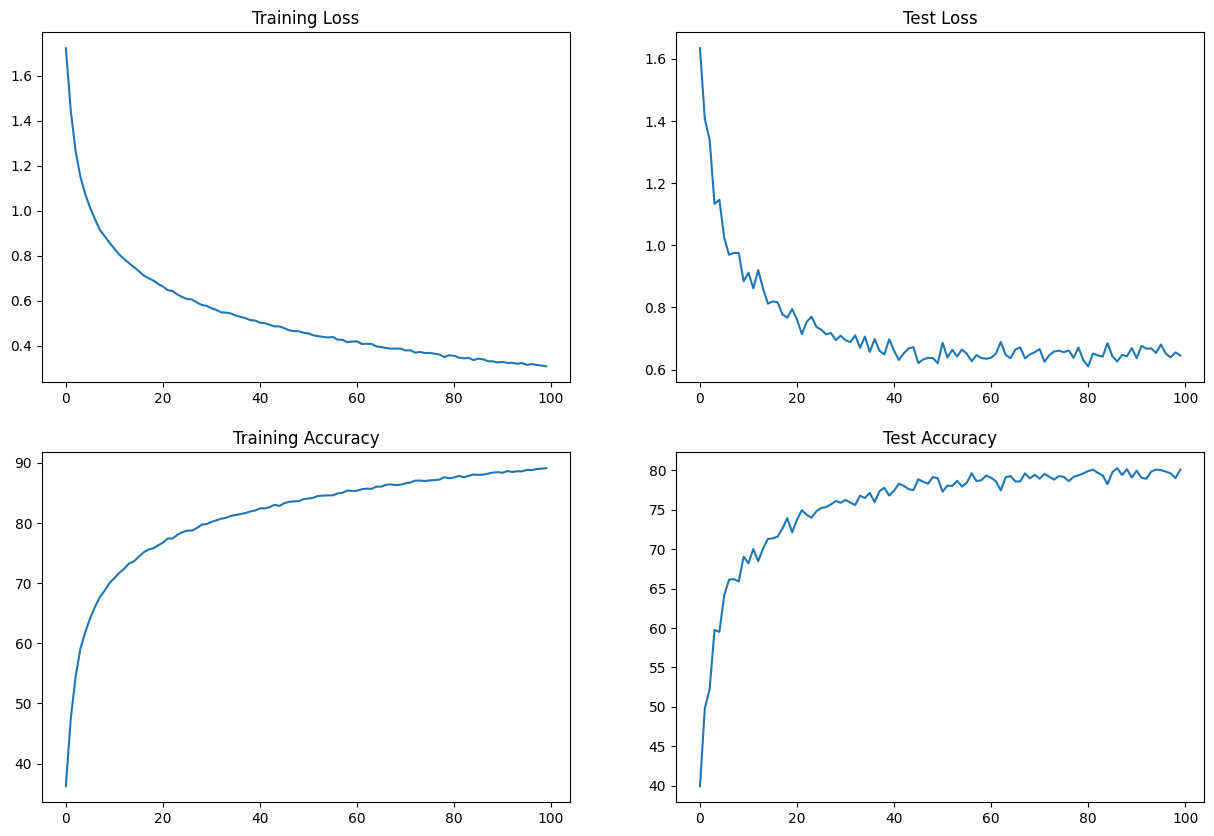

In [ ]:
#!pip install utils
# Display the loss and accuracy in tranining and Test Data.
import utils
from utils import display_plot

display_plot(train_losses,train_acc,test_losses,test_acc)


In [ ]:
from utils import convert_to_imshow_format

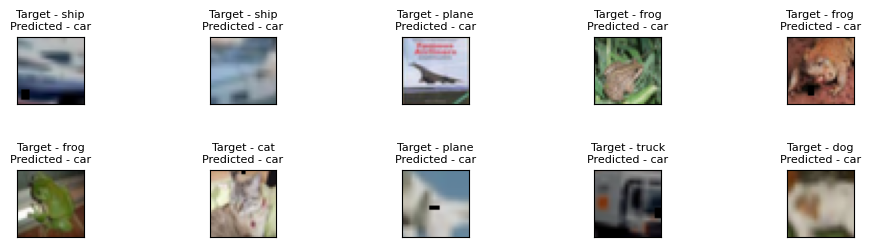

In [ ]:
# Shows the images in first batch of the test_loader 128 images, in 1*128 format with label
dataiter = iter(test_loader)
images, labels = next(dataiter)

#print(len(images))


#model = Net().to(device)
model = Net()
model.eval()

incorrect_pred = []

for idx,p in enumerate(predicted):
  #print("index --- ",idx)
  #print("predicted ---",classes[p])
  #print("Target ---",classes[labels[idx]])
  #print("Compare", classes[p] != classes[labels[idx]])
  if classes[p] != classes[labels[idx]]:

  #if p != labels[idx]:
    incorrect_pred.append(idx)
  #print(incorrect_pred)

index = 0
# show only the first 10 images in 2,5 format
fig, axes = plt.subplots(2, 5, figsize=(12,5))
plt.subplots_adjust(bottom=2.3, top=2.7, hspace=1)
#for idx, image in enumerate(images):
for p in range(0,2):
  for q in range(0,5):
    #print(idx)

    if index >= 10:
      break
    index=index+1
    #print(image.type)
    axes[p,q].imshow(convert_to_imshow_format(images[incorrect_pred[index]]))
    axes[p,q].set_title('Target - ' + classes[labels[incorrect_pred[index]]]+'\n'+'Predicted - '+ classes[predicted[incorrect_pred[index]]],fontsize = 8)
    axes[p,q].set_xticks([])
    axes[p,q].set_yticks([])


## Model 3

Results:

*   Parameters: Total params: 35,060
*   Train: (68.34)%
*   Test set: (73.20%)
*   EPOCH : 20


*   Analysis:
1. Model is underfitting.
2. The accuracy has reached the 73.20% with the Batch Normalization.
